In [ ]:
import sys
from PIL import Image
import sklearn
import matplotlib
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img, to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import cv2
import pandas as pd


In [ ]:
train_dir = '/content/drive/MyDrive/Các kì học tại HUS/B. Học kì 6 tại HUS/Seminar /Nghiên cứu/archive/train/'
test_dir = '/content/drive/MyDrive/Các kì học tại HUS/B. Học kì 6 tại HUS/Seminar /Nghiên cứu/archive/test/'

In [ ]:
CATEGORIES = ['angry','disgust','fear','happy','neutral', 'sad', 'surprise']

In [ ]:
training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(train_dir, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                img_gray = cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY)
                new_array=cv2.resize(img_gray,(48,48))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

FileNotFoundError: ignored

In [ ]:
test_data=[]
def create_test_data():
    for category in CATEGORIES:
        path=os.path.join(test_dir, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                img_gray = cv2.cvtColor(img_array,cv2.COLOR_BGR2GRAY)
                new_array=cv2.resize(img_gray,(48,48))
                test_data.append([new_array,class_num])
            except Exception as e:
                pass
create_test_data()

In [ ]:
x_train=[]
y_train=[]

for categories, label in training_data:
    x_train.append(categories)
    y_train.append(label)

In [ ]:
x_test=[]
y_test=[]

for categories, label in test_data:
    x_test.append(categories)
    y_test.append(label)

In [ ]:
# preprocessing the images

# convert each image to 1 dimensional array
X = np.array(x_train).reshape(len(x_train),-1)
Y = np.array(y_train)

# normalize the data to 0 - 1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(28709, 2304)
(2304,)


In [ ]:
from sklearn.cluster import MiniBatchKMeans

n_emoi = len(np.unique(y_test))
print(n_emoi)

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_emoi)

# Fit the model to the training data
kmeans.fit(X)

7


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=7)

In [ ]:
kmeans.labels_

array([4, 2, 5, ..., 6, 3, 0])

In [ ]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels[0]))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))

    return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """

    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key

    return predicted_labels


In [ ]:
# test the infer_cluster_labels() and infer_data_labels() functions
cluster_labels = infer_cluster_labels(kmeans, Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(Y[:20])

[3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 3 3]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
from sklearn import metrics

def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [ ]:
clusters = [7, 16, 64, 148, 256]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)

    # print cluster metrics
    calculate_metrics(estimator, X, Y)

    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)

    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 7
Inertia: 2708777.569202777
Homogeneity: 0.016501453838140636
Accuracy: 0.25577345083423314



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 16
Inertia: 2475428.0832889043
Homogeneity: 0.01884015328122933
Accuracy: 0.2566094256156606



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 64
Inertia: 2158005.870487685
Homogeneity: 0.030353417003984053
Accuracy: 0.27388623776516074



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 148
Inertia: 2016505.4221148212
Homogeneity: 0.04192097849650716
Accuracy: 0.28391793514228986



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 256
Inertia: 1945946.6180203161
Homogeneity: 0.054705054268880914
Accuracy: 0.29381030338918107



In [ ]:
# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0 - 1
X_test = X_test.astype(float) / 255.

# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, Y)

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)

# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.2712454722764001



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Admin\AppData\Local\Temp\ipykernel_10416\3902057193.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


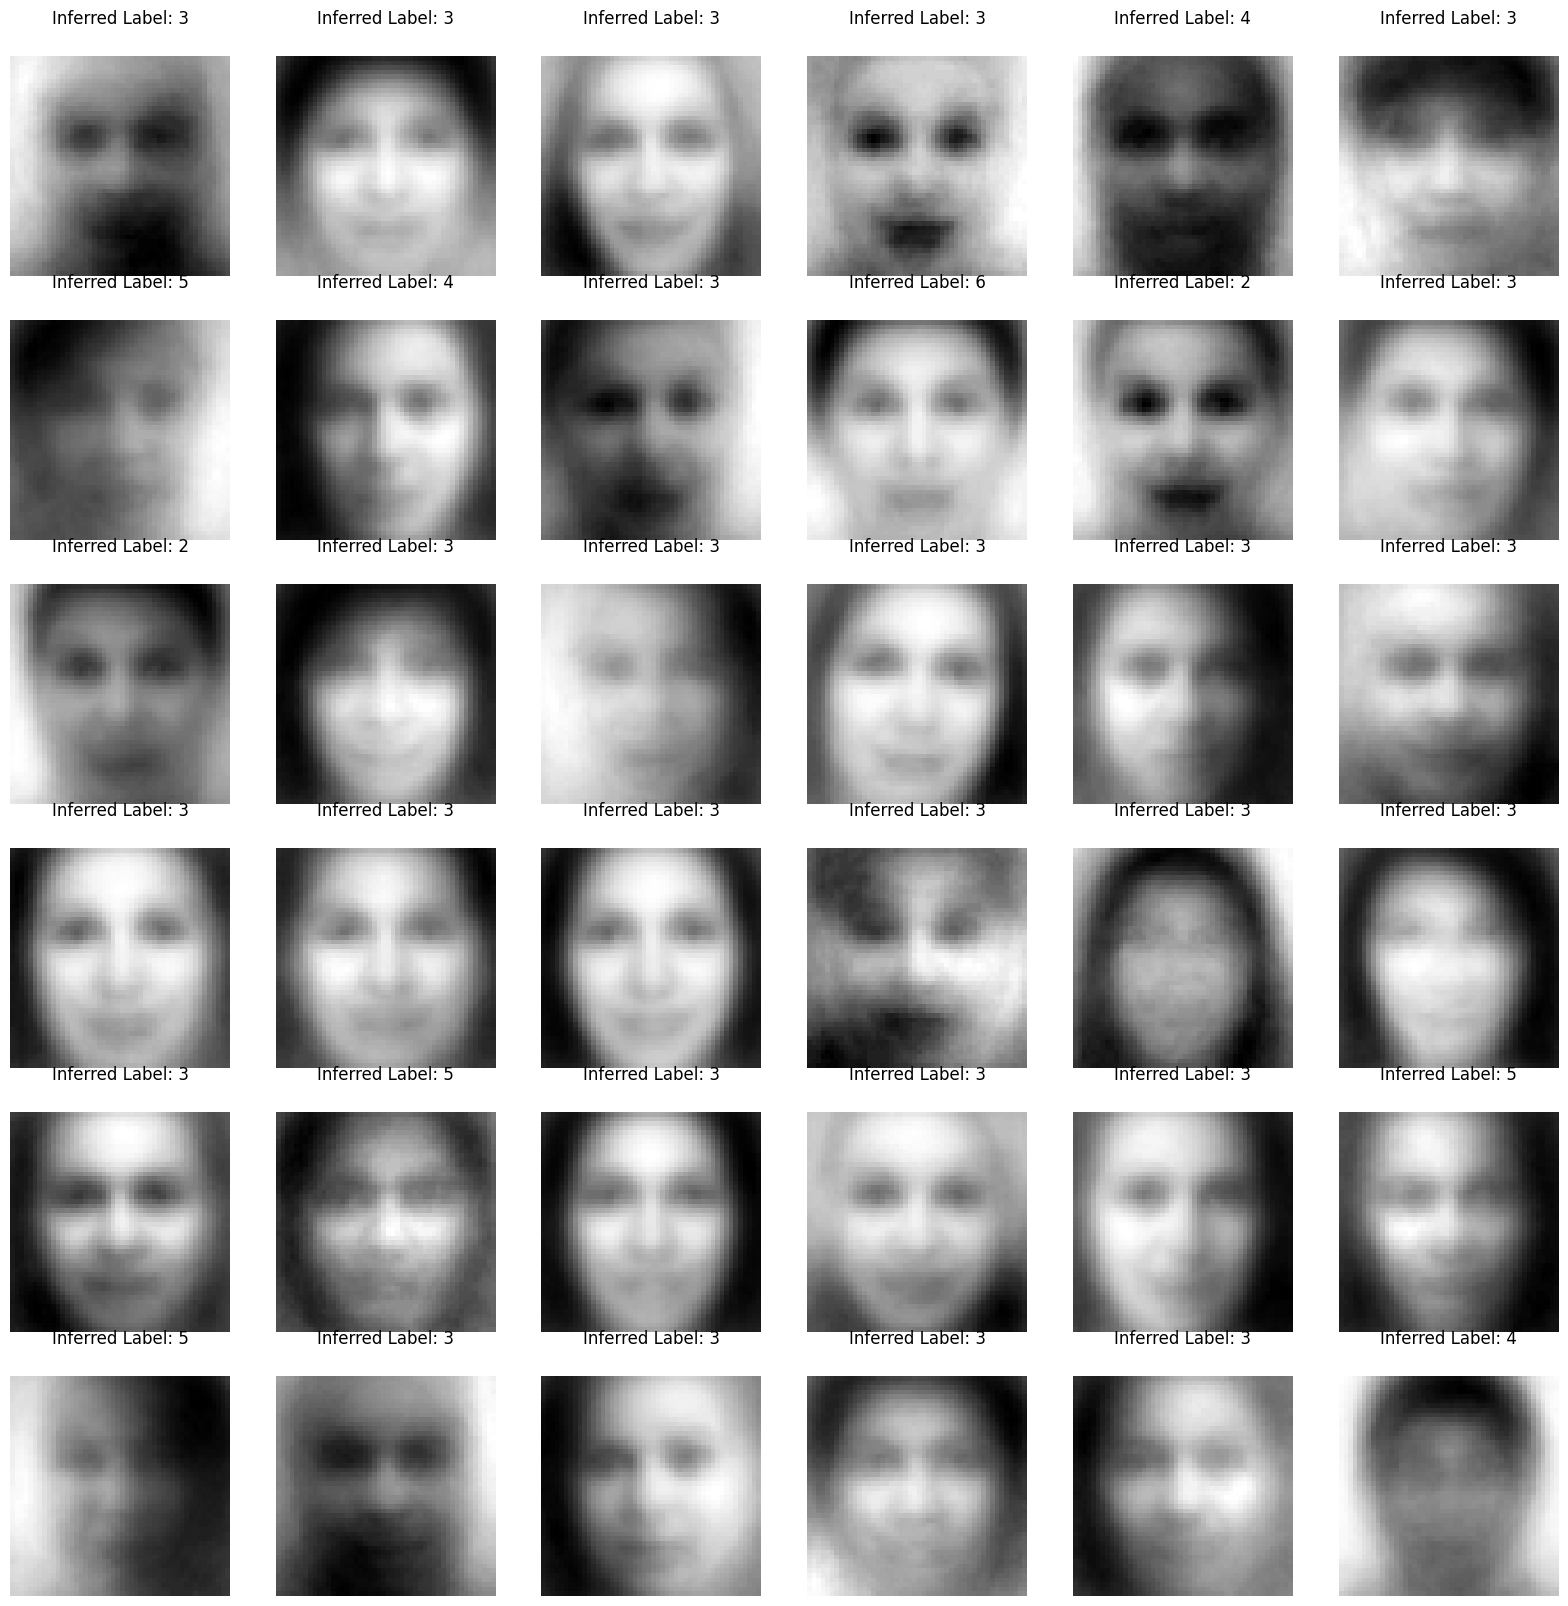

In [ ]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 48, 48)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):

    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))

    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')

# display the figure
fig.show()